# 收益率溢出效应

In [1]:
import warnings

# 关闭所有警告
warnings.filterwarnings("ignore")

# 你可以在此处放置你的代码
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg') 
plt.rcParams['font.sans-serif'] = 'Songti SC'  # 设置字体为SimHei
plt.rcParams['axes.unicode_minus'] = False  # 解决负号“-”显示异常

from importlib import reload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 对数收益率

In [2]:
df = pd.read_csv('datasets/log_final_df.csv', index_col=0)
df.index = pd.to_datetime(df.index)
#df = df.iloc[:,2:]

In [3]:
#df = df.apply(np.log).diff()
#df = df.iloc[1:]
df.shape, df.dropna(axis=1).shape

((1402, 8), (1402, 8))

In [4]:
from tvpvar import TVPVAR# Create an instance of our TVPVAR class with our observed dataset y
#df = df[['地缘政治', '原油','天然气','焦炭' ]]
#df = df[['气候政策', '新能源', '碳价']]
#df = df.drop(['绿色债券'], axis=1)
mod = TVPVAR(df)

/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [5]:
initial_obs_cov = np.cov(df.T)
initial_state_cov_diag = [0.01] * mod.k_states

# Update H and Q
mod.update_variances(initial_obs_cov, initial_state_cov_diag)

# Perform Kalman filtering and smoothing
# (the [] is just an empty list that in some models might contain
# additional parameters. Here, we don't have any additional parameters
# so we just pass an empty list)
initial_res = mod.smooth([])
initial_res.states.filtered.columns = [i.replace('L1.', '') for i in initial_res.states.filtered.columns]
initial_res.states.filtered.index = df.index[1:]


/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:2997: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'
/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:2997: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'
/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:2997: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'


## 全局溢出效应

### 地缘政治风险、气候政策风险、传统能源和绿色市场之间的静态溢出指数

In [53]:
spillover_matrix = {}
s = initial_res.states.filtered.mean()
for i in  df.columns:
    spillover_matrix[i] = {}
    for j in s.index:
        if '->' not in j: continue
        if j.split('->')[1] == i:
            spillover_matrix[j.split('->')[1]][j.split('->')[0]] = s[j]

In [118]:
s_df = pd.DataFrame(spillover_matrix).abs()
sum_1 = s_df.sum(axis=1)
sum_1.name = '溢入'
s_df2 = pd.concat([s_df, sum_1], axis=1)
# -----------
sum_0 = s_df.sum(axis=0)
ss = sum_0.sum()
sum_0 = sum_0.to_dict()
sum_0['溢入'] = ss
sum_0 = pd.DataFrame({'溢出':sum_0})
# ----------
s_df3 = pd.concat([s_df2, sum_0.T], axis=0)
s_df3.round(3)

,新能源指数,绿色债券指数,碳价,INE原油,天然气价格,焦炭价格,溢入
新能源指数,0.439,0.002,0.121,0.030,0.020,0.069,0.681
绿色债券指数,0.085,0.082,0.129,0.237,0.200,0.597,1.331
碳价,0.038,0.000,0.478,0.015,0.003,0.025,0.560
INE原油,0.045,0.001,0.017,0.384,0.042,0.034,0.521
天然气价格,0.007,0.004,0.005,0.014,0.320,0.012,0.362
焦炭价格,0.000,0.001,0.117,0.006,0.016,0.450,0.590
溢出,0.614,0.090,0.868,0.686,0.601,1.186,4.044


### 传统能源和绿色能源市场的静态溢出指数

In [112]:
df = pd.read_csv('datasets/log_final_df.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df= df.drop(['地缘政治', '气候政策'], axis=1)
df.shape, df.dropna(axis=1).shape

((1402, 6), (1402, 6))

In [113]:
from tvpvar import TVPVAR
mod = TVPVAR(df)

In [114]:
initial_obs_cov = np.cov(df.T)
initial_state_cov_diag = [0.01] * mod.k_states

# Update H and Q
mod.update_variances(initial_obs_cov, initial_state_cov_diag)
initial_res = mod.smooth([])
initial_res.states.filtered.columns = [i.replace('L1.', '') for i in initial_res.states.filtered.columns]
initial_res.states.filtered.index = df.index[1:]


In [116]:
spillover_matrix = {}
s = initial_res.states.filtered.mean()
for i in  df.columns:
    spillover_matrix[i] = {}
    for j in s.index:
        if '->' not in j: continue
        if j.split('->')[1] == i:
            spillover_matrix[j.split('->')[1]][j.split('->')[0]] = s[j]

In [117]:
s_df = pd.DataFrame(spillover_matrix).abs()
sum_1 = s_df.sum(axis=1)
sum_1.name = '溢入'
s_df2 = pd.concat([s_df, sum_1], axis=1)
# -----------
sum_0 = s_df.sum(axis=0)
ss = sum_0.sum()
sum_0 = sum_0.to_dict()
sum_0['溢入'] = ss
sum_0 = pd.DataFrame({'溢出':sum_0})
# ----------
s_df3 = pd.concat([s_df2, sum_0.T], axis=0)
s_df3.round(2)

,新能源指数,绿色债券指数,碳价,INE原油,天然气价格,焦炭价格,溢入
新能源指数,0.44,0.00,0.12,0.03,0.02,0.07,0.68
绿色债券指数,0.08,0.08,0.13,0.24,0.20,0.60,1.33
碳价,0.04,0.00,0.48,0.02,0.00,0.02,0.56
INE原油,0.04,0.00,0.02,0.38,0.04,0.03,0.52
天然气价格,0.01,0.00,0.00,0.01,0.32,0.01,0.36
焦炭价格,0.00,0.00,0.12,0.01,0.02,0.45,0.59
溢出,0.61,0.09,0.87,0.69,0.60,1.19,4.04


## 净溢出效应

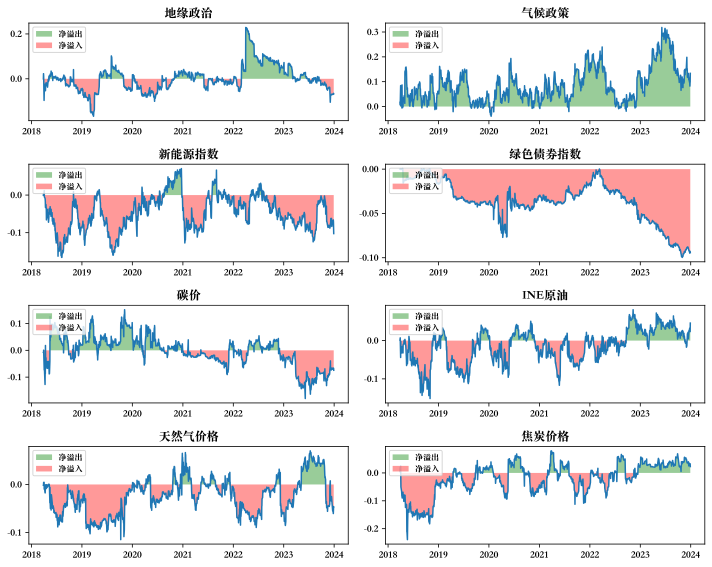

In [14]:
fig, axes = plt.subplots(4, 2, figsize=(10, 8))
ax = axes.ravel()
ax_num = 0
for i in df.columns:
    #print(i)
    receive_df, send_df = pd.DataFrame(), pd.DataFrame()
    for j in initial_res.states.filtered.columns:
        if '->%s' %i in j and '%s->%s' %(i,i) not in j:   # receive
            send_df = pd.concat([send_df, initial_res.states.filtered[j]], axis=1)
        elif '%s->' %i in j and '%s->%s' %(i,i) not in j:  # send
            receive_df = pd.concat([receive_df, initial_res.states.filtered[j]], axis=1)
    #receive_df.mean(axis=1).plot()
    #send_df.mean(axis=1).plot()
    x = receive_df.index
    y = send_df.mean(axis=1).abs() - receive_df.mean(axis=1).abs()
    ax[ax_num].plot(x, y)
    ax[ax_num].fill_between(x, y, 0, where=(y > 0), facecolor='green', alpha=0.4, interpolate=True, label='净溢出')
    ax[ax_num].fill_between(x, y, 0, where=(y <= 0), facecolor='red', alpha=0.4, interpolate=True, label='净溢入')


    #
    # 修改图例框的样式为直角
    ax[ax_num].legend(prop={'size': 8}, loc='upper left')
    # legend = ax[ax_num].legend()
    # frame = legend.get_frame()
    # frame.set_edgecolor('black')  # 设置边框颜色
    # frame.set_linewidth(1)         # 设置边框宽度
    # frame.set_facecolor('white')   # 设置背景颜色
    # frame.set_alpha(1)             # 设置透明度（1为不透明）
    
    ax[ax_num].set_title(i)
    ax_num += 1
plt.tight_layout()
plt.savefig('images/净溢出.svg')

## 俄乌战争

In [8]:
spillover_matrix = {}
s = initial_res.states.filtered.loc['2022-04-29']
for i in  df.columns:
    spillover_matrix[i] = {}
    for j in s.index:
        if '->' not in j: continue
        if j.split('->')[0] == i:
            spillover_matrix[j.split('->')[0]][j.split('->')[1]] = s[j]

/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:2997: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'


In [9]:
net_spillover_matrix = {}
for i in spillover_matrix:
    net_spillover_matrix[i] = {}
    for j in spillover_matrix[i]:
        if abs(spillover_matrix[i][j]) - abs(spillover_matrix[j][i]) > 0:
            net_spillover_matrix[i][j] = abs(spillover_matrix[i][j]) - abs(spillover_matrix[j][i])
        elif abs(spillover_matrix[i][j]) - abs(spillover_matrix[j][i]) == 0:
            net_spillover_matrix[i][j] = abs(spillover_matrix[i][j])
        else:
            net_spillover_matrix[i][j] = 0
        #print(i, j, spillover_matrix[i][j] , spillover_matrix[j][i] )

In [10]:
net_spillover_matrix = pd.DataFrame(net_spillover_matrix).abs()
net_spillover_matrix.to_csv('datasets/俄乌战争爆发后.csv')

## 气候政策

/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:2997: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'


KeyError: '气候政策->新能源'

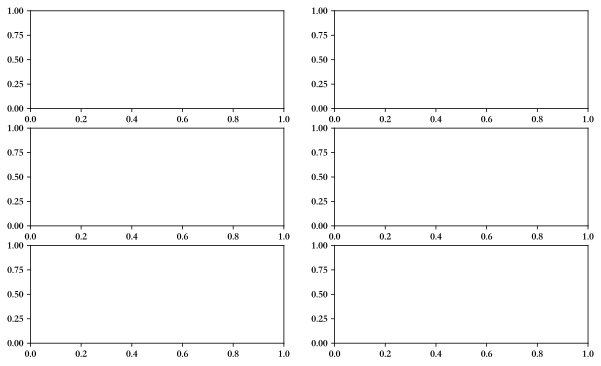

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(10, 6))
ax = axes.ravel()
ax_num = 0
for i in ['气候政策']:
    #print(i)
    receive_df, send_df = pd.DataFrame(), pd.DataFrame()
    for j in ['新能源','绿色债券','碳价','原油','天然气','焦炭']:
        send_df = pd.concat([send_df, initial_res.states.filtered['%s->%s' %(i,j)]], axis=1)
        receive_df = pd.concat([receive_df, initial_res.states.filtered['%s->%s' %(j,i)]], axis=1)
        x = receive_df.index
        y = -(send_df.mean(axis=1).abs() - receive_df.mean(axis=1).abs())
        ax[ax_num].plot(x, y)
        ax[ax_num].fill_between(x, y, 0, where=(y > 0), facecolor='green', alpha=0.4, interpolate=True, label='净溢出')
        ax[ax_num].fill_between(x, y, 0, where=(y <= 0), facecolor='red', alpha=0.4, interpolate=True, label='净溢入')
        ax[ax_num].legend(prop={'size': 8}, loc='upper left')
        ax[ax_num].set_title('%s->%s' %(i,j))
        ax_num += 1
plt.tight_layout()
plt.savefig('images/碳政策.svg')